# PHYS 210, Homework 05
Due Monday, Sep 22, 2025 at the start of class on Canvas

## *About this homework assignment*

This homework assignment is designed to get everybody started on their Project 01. It is considered Stage 1 of a 3-stage process in developing your project, as described in the [Project 01 - Destructive Collisions: Instructions & Assessment Guidelines](https://physics210.github.io/p210-2025/Project01-instructions_and_assessment.html) document.

### Task 1: Fix the starter code
Update the starter code in the "Your Task 1 and Task 2 code" cell below so that the collision between the two objects is handled correctly.

### Task 2: Add plots
Add one or more well-captioned and well-labeled plots (not animations) that show the kinematic behaviour of the two objects. 

It’s up to you exactly what you plot, but the idea is that these plots provide you (and the reader) with insight into the behaviour of these objects within the simulation. These types of plots can also be extremely valuable in troubleshooting your code, or otherwise validating that your simulation is behaving as intended.

### Task 3: Test that your code handles a range of initial conditions and parameters well
Copy your working code into the Task 3 cells below.

Try at least two different sets of initial conditions that you feel could result in unexpected behaviour in your simulation. Examples include making values–such as the initial kinematic quantities or physical properties—significantly smaller or larger than the ones provided. In each case describe which values you changed, why you thought these values might result in unexpected behaviour, and if they did actually result in any unexpected behaviour. If the unexpected behaviour is something that should be fixed, try your best to fix it.

## *Your Task 1 and Task 2 code*

Modify the code below as much as needed to accomplish each task. There is a backup copy of the code at the bottom of the document for reference. Add additional cells to this section as needed

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass

In [2]:
@dataclass
class RigidBody:
    initial_position: float
    initial_velocity: float
    initial_acceleration: float
    mass: float
    color: str
    name: str
    
    time:         np.array = None
    position:     np.array = None
    velocity:     np.array = None
    acceleration: np.array = None
    energy:       np.array = None
    momentum:     np.array = None
    
    def init(self, n):
        self.position     = np.zeros(n)
        self.velocity     = np.zeros(n)
        self.acceleration = np.zeros(n)
        self.energy       = np.zeros(n)
        self.momentum     = np.zeros(n)
        
        self.position[0]     = self.initial_position
        self.velocity[0]     = self.initial_velocity
        self.acceleration[0] = self.initial_acceleration
        
    def __hash__(self):
        return hash(self.name)
        
    def distance_to(self, other_body, i):
        return np.sqrt(np.sum((self.position[i] - other_body.position[i])**2))

    def collided_with(self, other_body, collision_radius, i):
        return self.distance_to(other_body, i) <= collision_radius
    
    def near_barrier(self, bottom_barrier, top_barrier, collision_radius, i):
        return \
            abs(self.position[i] - bottom_barrier) <= collision_radius or \
            abs(self.position[i] - top_barrier) <= collision_radius

In [3]:
def simulate(objects, time_range, dt, 
             collision_radius=0.1, 
             bottom_barrier=-10, 
             top_barrier=10):
    time = np.arange(time_range[0], time_range[1], dt)
    total_frames = np.size(time)
    collisions = set()
    
    for body in objects:
        body.init(total_frames)
    
    for i in range(1, total_frames):
        # update positions
        for body in objects:
            body.position[i] = body.position[i-1] + body.velocity[i-1]     * dt
            body.velocity[i] = body.velocity[i-1] + body.acceleration[i-1] * dt
            body.acceleration[i] = body.acceleration[i-1]
        
        # detect collisions
        to_invert = set()
        
        for first_body_idx, body in enumerate(objects):
            for other_body in objects[first_body_idx+1:]:
                if body.collided_with(other_body, collision_radius, i):
                    collisions.add((time[i], body.position[i]))
                    to_invert.add(body)
                    to_invert.add(other_body)
                    
        for body in objects:
            if body.near_barrier(bottom_barrier, top_barrier, collision_radius, i):
                to_invert.add(body)
        
        for body in to_invert:
            body.velocity[i] *= -1
            
    # ending calculations
    for body in objects:
        body.momentum = body.mass * abs(body.velocity)
        body.energy = (1/2) * body.mass * body.velocity ** 2
        
    # transpose collisions
    collisions = np.array(list(zip(*collisions)))
        
    return time, collisions

In [4]:
def plot_results(objects, time, collisions):
    fig, axs = plt.subplots(4,1, sharex=True, figsize=(8,8))

    # position
    for body in objects:
        axs[0].plot(time, body.position, 
                    color=body.color, 
                    label=body.name,
                    linestyle='dashed')
    axs[0].scatter(collisions[0], collisions[1], label='Collisions')
    axs[0].axhline(y=10, color='black', label='Top Barrier')
    axs[0].axhline(y=-10, color='black', label='Bottom Barrier')
    axs[0].set_ylabel('Position\n(m)')
    axs[0].set_title('Position vs. Time')
    axs[0].legend()

    # velocity
    for body in objects:
        axs[1].plot(time, body.velocity, 
                    color=body.color, 
                    label=body.name)
    axs[1].set_ylabel('Velocity\n(m/s)')
    axs[1].set_title('Velocity vs. Time')
    axs[1].legend()

    # kinetic energy
    total_energy = np.zeros_like(time)
    for body in objects:
        axs[2].plot(time, body.energy * 1e3, 
                    color=body.color, 
                    label=body.name)
        total_energy = total_energy + body.energy
    axs[2].plot(time, total_energy * 1e3, color='green', label='Total Kinetic Energy')
    axs[2].set_ylabel('Kinetic Energy\n(mJ)')
    axs[2].set_title('Kinetic Energy vs. Time')
    axs[2].legend()

    # momentum
    total_momentum = np.zeros_like(time)
    for body in objects:
        axs[3].plot(time, body.momentum * 1e2, 
                    color=body.color, 
                    label=body.name)
        total_momentum = total_momentum + body.momentum
    axs[3].plot(time, total_momentum * 1e2, color='green', label='Total Momentum')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('Momentum\n(kg*m/s*10^2)')
    axs[3].set_title('Momentum vs. Time')
    axs[3].legend()

    plt.show()

In [5]:
def simulate_and_plot(objects, time_range, dt):
    time, collisions = simulate(objects, time_range, dt)
    plot_results(objects, time, collisions)

In [6]:
object_1 = RigidBody(
    initial_position = -5,
    initial_velocity =  2,
    initial_acceleration = 0,
    mass = 0.01,
    color = 'lightblue',
    name = 'Object 1'
)

object_2 = RigidBody(
    initial_position =  7,
    initial_velocity = -1,
    initial_acceleration = 0,
    mass = 0.001,
    color = 'orange',
    name = 'Object 2'
)

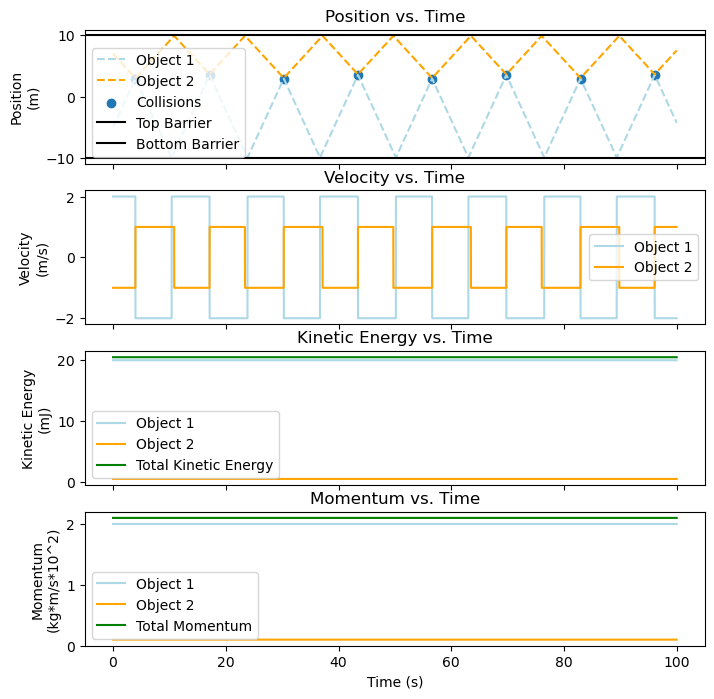

In [7]:
simulate_and_plot([object_1, object_2], time_range=(0, 100), dt=0.01)

**Caption:** The position, velocity, kinetic energy, and momentum graphs over the time of the first simulation, showing the collision between object 1 with a mass of 0.01 kg and initial conditions $(x_1=-5 \text{ }m, v_1=2 \text{ }m/s, a_1 = 0 \text{ }m/s^2)$ and object 2 with a mass of 0.001 kg and initial conditions $(x_2=7 \text{ }m, v_2 = -1 \text{ } m/s, a_2 = 0 \text{ } m/s^2),$ running from $t=0 \text{ } s$ to $t=100 \text{ } s$ with $\delta t = 0.01 \text{ } s$. All collisions are elastic with only a change in direction, resulting in constant kinetic energy and momentum on all objects. Similarly, speed is constant on all objects, and with barriers at $x=\pm 10$, collisions happen periodically.

## *Your Task 3 code*


### Your first set of new initial conditions

In [8]:
object_1 = RigidBody(
    initial_position = -5,
    initial_velocity =  2,
    initial_acceleration = 0,
    mass = 0.01,
    color = 'lightblue',
    name = 'Object 1'
)

object_2 = RigidBody(
    initial_position =  7,
    initial_velocity = -1,
    initial_acceleration = -1,
    mass = 0.001,
    color = 'orange',
    name = 'Object 2'
)

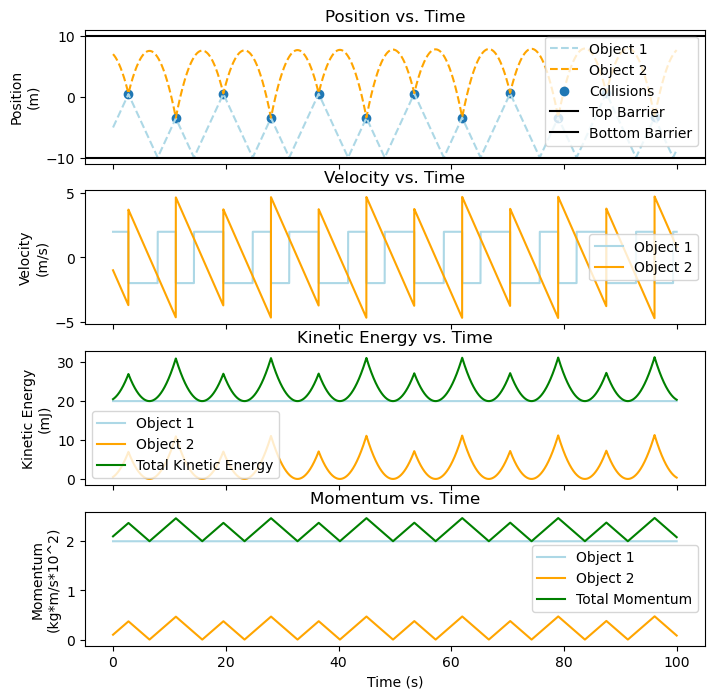

In [9]:
simulate_and_plot([object_1, object_2], time_range=(0, 100), dt=0.01)

**Caption:** The position, velocity, kinetic energy, and momentum graphs over the time of the second simulation, showing the collision between object 1 with a mass of 0.01 kg and initial conditions $(x_1=-5 \text{ }m, v_1=2 \text{ }m/s, a_1 = 0 \text{ }m/s^2)$ and object 2 with a mass of 0.001 kg and initial conditions $(x_2=7 \text{ }m, v_2 = -1 \text{ } m/s, a_2 = -1 \text{ } m/s^2),$ running from $t=0 \text{ } s$ to $t=100 \text{ } s$ with $\delta t = 0.01 \text{ } s$. All collisions are elastic with only a change in direction, but due to an input of constant acceleration on Object 2, total kinetic energy and momentum of the system are not held constant but rather increase and decrease periodically based on the direction of the velocity with respect to the direction of the acceleration, giving the jagged "toothlike" graphs. Once again, collisions are still periodic, as seen in the position graph.

#### Describe which values you changed, why you thought these values might result in unexpected behaviour, and if they did actually result in any unexpected behaviour.

I kept all of the initial conditions the same except I added a constant acceleration of -1 m/s to Object 2. This resulted in a non-constant total momentum and kinetic energy, and gives the jagged-looking graphs that can be seen in the kinetic energy vs. time graphs. This behavior was unexpected because I was intending to create a non-periodic collision graph (ideally, I wanted to create a somewhat random spread).

### Your second set of new initial conditions

In [16]:
object_1 = RigidBody(
    initial_position = -5,
    initial_velocity =  2,
    initial_acceleration = 2,
    mass = 0.01,
    color = 'lightblue',
    name = 'Object 1'
)

object_2 = RigidBody(
    initial_position =  7,
    initial_velocity = -1,
    initial_acceleration = -1,
    mass = 0.1,
    color = 'orange',
    name = 'Object 2'
)

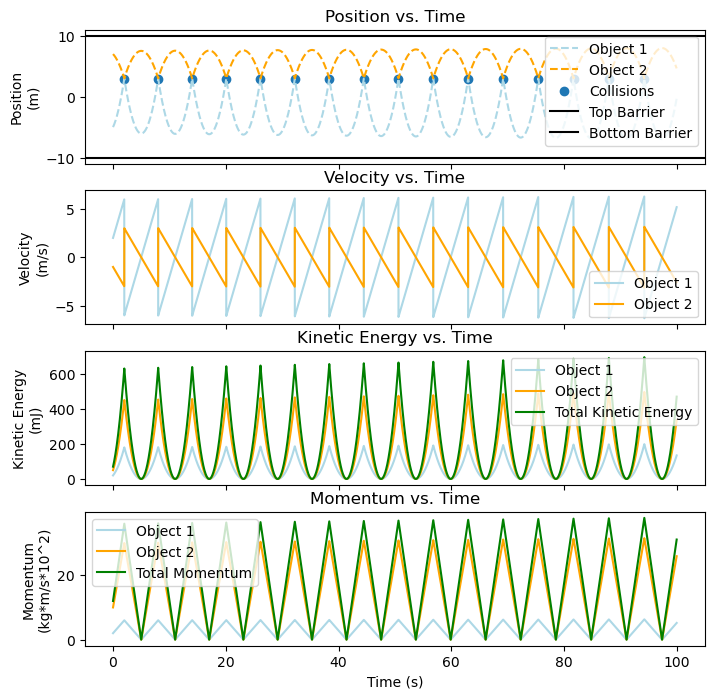

In [17]:
simulate_and_plot([object_1, object_2], time_range=(0, 100), dt=0.01)

**Caption:** The position, velocity, kinetic energy, and momentum graphs over the time of the third simulation, showing the collision between object 1 with a mass of 0.01 kg and initial conditions $(x_1=-5 \text{ }m, v_1=2 \text{ }m/s, a_1 = +2 \text{ }m/s^2)$ and object 2 with a mass of 0.1 kg and initial conditions $(x_2=7 \text{ }m, v_2 = -1 \text{ } m/s, a_2 = -1 \text{ } m/s^2),$ running from $t=0 \text{ } s$ to $t=100 \text{ } s$ with $\delta t = 0.01 \text{ } s$. Despite having acceleration on both objects, the collisions observed are still, once again, periodic, which gives credibility to the hypothesis that any constant acceleration whatsoever on the objects within the system is going to result in periodic behavior, and a functional input of force dependent on object conditions will produce random collision.

#### Describe which values you changed, why you thought these values might result in unexpected behaviour, and if they did actually result in any unexpected behaviour.

I was, once again, hoping to produce a random collision spread by adding in more acceleration. I gave Object 1 an acceleration of +2 m/s hoping that it may achieve this, but the irony is that all it did was move the collision points vertically. I was hoping for a random spread, but once again, it's still perfectly periodic. I hypothesize, now, that any constant acceleration/force within the system will produce periodic behavior, and I would need to vary acceleration/force based on the conditions of the object (such as defining some force $f$ as a function of $(x,t)$ or so). Another potential idea to test this theory is to add more objects to the system. 

## *Completing Homework 05 and submitting it to Canvas*
Before submitting your work, restart + rerun your entire notebook to make sure that everything runs correctly and without error.

To do this:
1. **Restart & Run All:** From the "Kernel" menu to the right of the "Cell" menu, select "Restart & Run All". This will restart the python Kernel, erasing all variables currently stored in memory so that when you "Run All" cells, you can ensure that if you were to run your notebook again on a later day, it would run as intended.
1. Look through the whole notebook and make sure there are no errors. Many questions have purposeful errors in the distributed version so make sure you have fixed them all such that "Restart & Run All" will run through the whole book and successfully print "The notebook ran without errors" at the end. If you have any trouble resolving the errors, please ask one of your classmates or ask us in class or on Piazza.

**Export notebook as HTML:** After you've executed and checked your notebook, choose: File => Save_and_Export_Notebook_As => HTML. This will download an HTML version of your notebook to your computer. This version is can not be executed or modified. You may need to disable any pop-up blockers to allow the file to be downloaded.

**Submit to Canvas:** Submit the html file that you just downloaded AND your .ipynb file to the Homework 05 submission quiz on Canvas.

## *Backup copy of the starter code for Project 01*
```python
### Starter code for Project 01

import numpy as np

# Constants
t0 = 0      # s
dt = 0.1    # s
t_max = 100 # s
n_steps = int( (t_max - t0) / dt) + 1 # Total number of steps
left_barrier = -10 # m
right_barrier = 10 # m

# Arrays to save simulation information
t = np.zeros(n_steps)
x1 = np.zeros(n_steps)
x2 = np.zeros(n_steps)
v1 = np.zeros(n_steps)
v2 = np.zeros(n_steps)

# Object 1
x1_initial = -5 # m
v1_initial = 2  # m/s
r1 = 0.05 # m
m1 = .01 # kg
x1[0] = x1_initial 
v1[0] = v1_initial 

# Object 2
x2_initial = 7  # m
v2_initial = -1 # m /s
r2 = 0.02 # m
m2 = .001 # kg
x2[0] = x2_initial 
v2[0] = v2_initial 


for i in range(1,n_steps):
    
    # Update kinematic variable for both objects
    x1[i] = x1[i-1] + v1[i-1] * dt
    x2[i] = x2[i-1] + v2[i-1] * dt
    v1[i] = v1[i-1]
    v2[i] = v2[i-1]
    t[i]  =  t[i-1] + dt

    # Check for collisions and update kinematic quantities as needed
    if x1[i] + r1 >= right_barrier or x1[i] - r1 <= left_barrier:
        v1[i] = -v1[i]

    if x2[i] + r2 >= right_barrier or x2[i] - r2 <= left_barrier:
        v2[i] = -v2[i]
```